# **Credit Card Fraud Detection using DNN**

Problem Type: Binary Classification
Key Challenge: Extreme class imbalance (fraud ≈ 0.17%)

Dataset: Kaggle – Credit Card Fraud Detection
Features are anonymized (V1–V28 from PCA), plus Time, Amount, and target Class.

### 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    confusion_matrix, classification_report, auc
)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping

import shap

import warnings
warnings.filterwarnings('ignore')

d:\Python\ml-projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load Dataset


In [2]:
df = pd.read_csv('creditcard.csv')

print(df.shape)
print(df['Class'].value_counts(normalize=True))

(284807, 31)
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


### 3. Exploratoey Data Analysis

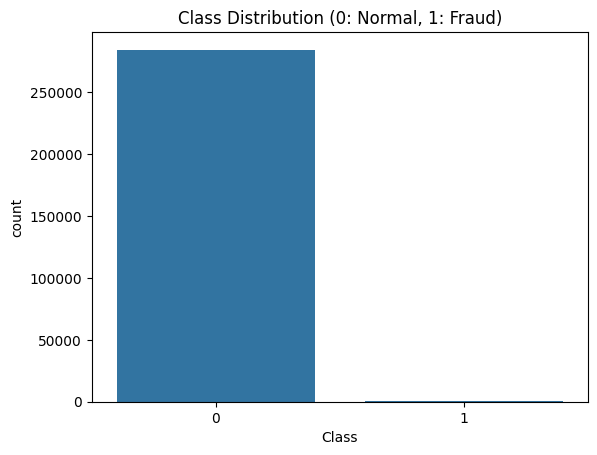

In [3]:
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0: Normal, 1: Fraud)")
plt.show()

### 4. Preprocessing


In [4]:
X = df.drop(['Class'], axis=1)
y = df['Class']

### 4. Feature Scaling


In [5]:
scaler = StandardScaler()

X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

### 5. Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 6. Handle Imbalance Data

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}


### 7. Build DNN Model

In [10]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

### 8. Train Model

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=2048,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.8808 - loss: 0.5123 - val_AUC: 0.9392 - val_loss: 0.4700
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9272 - loss: 0.3362 - val_AUC: 0.9568 - val_loss: 0.3013
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9562 - loss: 0.2538 - val_AUC: 0.9674 - val_loss: 0.2022
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9591 - loss: 0.2258 - val_AUC: 0.9814 - val_loss: 0.1616
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9750 - loss: 0.1860 - val_AUC: 0.9838 - val_loss: 0.1310
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9756 - loss: 0.1792 - val_AUC: 0.9863 - val_loss: 0.1199
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9737 - loss: 0.1821 - val_AUC: 0.9878 - val_loss: 0.1138
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9839 - loss: 0.1545 - val_AUC: 0.9884 - val_loss: 0.0998
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9856 - loss: 

### 9. Evaluate Model

##### Plot training history

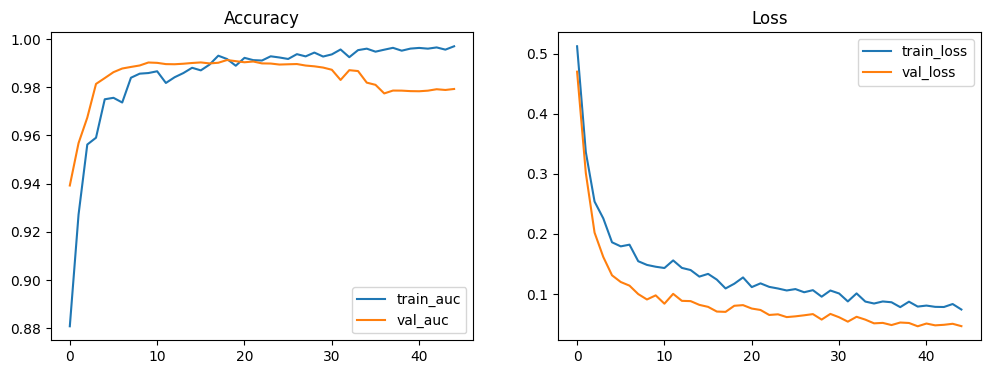

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['AUC'], label='train_auc')
plt.plot(history.history['val_AUC'], label='val_auc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

##### Predictions

In [18]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step


##### Confusion Matrix

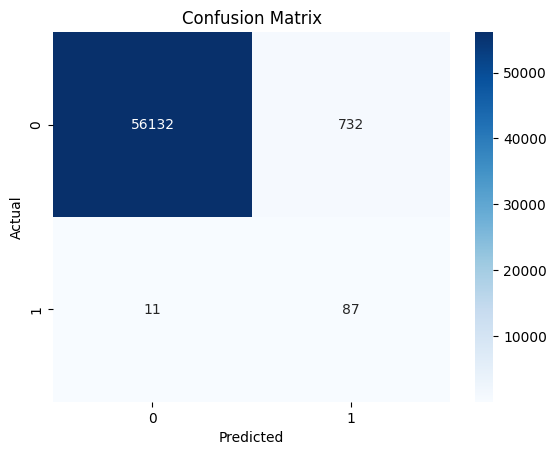

In [19]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Classification Report

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962



##### ROC-AUC

In [21]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9765092939257863


##### Precision-Recall Curve

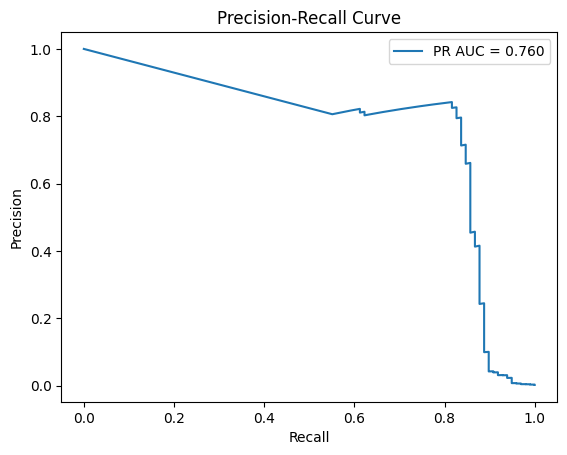

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_prob)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### 10. SHAP Explainability

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step


  2%|▏         | 1/50 [00:09<07:41,  9.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 949us/step


  4%|▍         | 2/50 [00:18<07:16,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step


  6%|▌         | 3/50 [00:27<07:10,  9.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 936us/step


  8%|▊         | 4/50 [00:36<06:54,  9.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 937us/step


 10%|█         | 5/50 [00:45<06:43,  8.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 913us/step


 12%|█▏        | 6/50 [00:53<06:29,  8.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 915us/step


 14%|█▍        | 7/50 [01:02<06:17,  8.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 925us/step


 16%|█▌        | 8/50 [01:11<06:06,  8.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 894us/step


 18%|█▊        | 9/50 [01:19<05:54,  8.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 931us/step


 20%|██        | 10/50 [01:28<05:46,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 910us/step


 22%|██▏       | 11/50 [01:36<05:36,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 950us/step


 24%|██▍       | 12/50 [01:45<05:29,  8.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 907us/step


 26%|██▌       | 13/50 [01:54<05:19,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 915us/step


 28%|██▊       | 14/50 [02:03<05:16,  8.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 915us/step


 30%|███       | 15/50 [02:11<05:05,  8.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 893us/step


 32%|███▏      | 16/50 [02:20<04:54,  8.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 996us/step


 34%|███▍      | 17/50 [02:29<04:53,  8.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 968us/step


 36%|███▌      | 18/50 [02:38<04:45,  8.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 948us/step


 38%|███▊      | 19/50 [02:47<04:36,  8.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step


 40%|████      | 20/50 [02:56<04:28,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 42%|████▏     | 21/50 [03:06<04:26,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 44%|████▍     | 22/50 [03:16<04:21,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 911us/step


 46%|████▌     | 23/50 [03:24<04:05,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 920us/step


 48%|████▊     | 24/50 [03:33<03:53,  8.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 929us/step


 50%|█████     | 25/50 [03:42<03:41,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 904us/step


 52%|█████▏    | 26/50 [03:50<03:30,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 957us/step


 54%|█████▍    | 27/50 [03:59<03:22,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step


 56%|█████▌    | 28/50 [04:08<03:12,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 927us/step


 58%|█████▊    | 29/50 [04:16<03:03,  8.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 920us/step


 60%|██████    | 30/50 [04:25<02:54,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 935us/step


 62%|██████▏   | 31/50 [04:34<02:45,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 878us/step


 64%|██████▍   | 32/50 [04:42<02:35,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 877us/step


 66%|██████▌   | 33/50 [04:53<02:36,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 922us/step


 68%|██████▊   | 34/50 [05:01<02:24,  9.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step


 70%|███████   | 35/50 [05:10<02:12,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 914us/step


 72%|███████▏  | 36/50 [05:18<02:02,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 880us/step


 74%|███████▍  | 37/50 [05:27<01:52,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 962us/step


 76%|███████▌  | 38/50 [05:36<01:45,  8.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step  


 78%|███████▊  | 39/50 [05:46<01:42,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 934us/step


 80%|████████  | 40/50 [05:55<01:32,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 82%|████████▏ | 41/50 [06:07<01:29,  9.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 84%|████████▍ | 42/50 [06:17<01:20, 10.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 957us/step


 86%|████████▌ | 43/50 [06:28<01:11, 10.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 88%|████████▊ | 44/50 [06:38<01:01, 10.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 90%|█████████ | 45/50 [06:47<00:49,  9.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 5s 827us/step


 92%|█████████▏| 46/50 [06:58<00:40, 10.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 930us/step


 94%|█████████▍| 47/50 [07:07<00:29,  9.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 96%|█████████▌| 48/50 [07:17<00:19,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 98%|█████████▊| 49/50 [07:27<00:09,  9.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 50/50 [07:37<00:00,  9.16s/it]


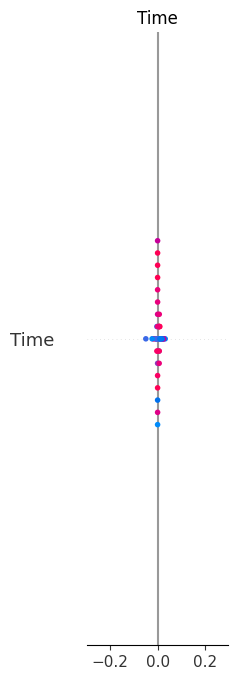

In [23]:
explainer = shap.KernelExplainer(model.predict, X_train.sample(100))
shap_values = explainer.shap_values(X_test.sample(50))
shap.summary_plot(shap_values, X_test.sample(50))

### 11. Save trained model

In [26]:
model.save("model/credit_card_detection.h5")

import joblib
joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']